In [1]:
%pip install pyspark
%pip install pymongo
%pip install dnspython
%pip install numpy
%pip install seaborn
import seaborn as sns
import pyspark
import pymongo
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import collect_list, weekofyear

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pyspark findspark
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pandas as pd

In [4]:
spark = SparkSession.builder \
    .appName("Electricity Load Prediction") \
    .getOrCreate()

In [5]:
# Reading Excel file into a pandas DataFrame
pandas_df = pd.read_excel("./data/train_dataframes.xlsx")

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)

# Show the first few rows to understand the training set
spark_df.show()

c:\Users\Jerrod\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:479: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+-------------------+---------+-----------------+---------+-----------------+---------+-------+-------+----------+---------+-----------------+-----------------+
|           datetime| week_X-2|         week_X-3| week_X-4|           MA_X-4|dayOfWeek|weekend|holiday|Holiday_ID|hourOfDay|          T2M_toc|           DEMAND|
+-------------------+---------+-----------------+---------+-----------------+---------+-------+-------+----------+---------+-----------------+-----------------+
|2015-01-31 01:00:00| 962.2865|906.9580000000001|  970.345|        938.00485|        1|      1|      0|         0|        1|25.30849609375002|         954.2018|
|2015-01-31 02:00:00| 933.3221|         863.5135| 912.1755|       900.284075|        1|      1|      0|         0|        2|25.14144287109377|913.8660000000001|
|2015-01-31 03:00:00| 903.9817|         848.4447| 900.2688|881.7043249999999|        1|      1|      0|         0|        3|25.00673828125002|         903.3637|
|2015-01-31 04:00:00| 900.9995|   

In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

# feature columns are:
# week_X-2 lagged features capable of capturing temporal trends
# week_X-3
# week_X-4

# MA_X-4 moving average capable of capturing seasonal components
# dayOfWeek daily and seasonal behavior
# weekend
# holiday
# Holiday_ID
# hourOfDay

# T2M_toc weather feature

# Define a list called 'feature_columns' containing the names of all the columns in the DataFrame
# that we want to use as features for training our ML model.
# These columns include lagged electricity demand data, moving average, and various time and weather variables.
feature_columns = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday", "Holiday_ID", "hourOfDay", "T2M_toc"]

# Assemble features
# Initialize the VectorAssembler transformer from Spark's MLlib library.
# 'inputCols' specifies the list of column names that should be used as features.
# 'outputCol' specifies the name of the new column that will contain the assembled feature vectors.
# Output column is named 'assembled_features'.
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Scale features
# Initialize the StandardScaler transformer from Spark's MLlib library.
# 'inputCol' specifies the name of the column containing the assembled feature vectors that we want to scale.
# In this case, the input column is 'assembled_features'.
# 'outputCol' specifies the name of the new column that will contain the scaled feature vectors.
# The new column is named 'features'.
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="DEMAND")

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, scaler, lr])

# Train the model
model = pipeline.fit(spark_df)

In [7]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize a RandomForestRegressor model using Spark's MLlib.
# This creates an instance of a Random Forest model tailored for regression tasks, aiming to predict a continuous variable.

# 'featuresCol="features"': 
# Tells the model to use the column named 'features' as the input feature vectors for training.
# These feature vectors are numerical representations that encapsulate all the feature columns we've specified earlier.
# They have been assembled and scaled, making them suitable for ML algorithms.
# In Random Forest, these vectors are used by each decision tree in the forest to make individual predictions, which are then averaged.

# 'labelCol="DEMAND"': 
# Specifies that the column named 'DEMAND' contains the actual values of the target variable we are trying to predict.
# This is what the model compares its predictions to during training in order to learn the best possible mapping from features to the target variable.
# In the context of your problem, DEMAND likely represents the electricity load at each given hour, and the model will attempt to predict this load based on the input features.

# In summary, we're preparing to train a Random Forest model to predict 'DEMAND' based on the assembled and scaled features.
# Each tree in this Random Forest will look at these features to make its own prediction, and the final model output is typically an average of these individual tree predictions.
rf = RandomForestRegressor(featuresCol="features", labelCol="DEMAND")

# Create a Spark ML Pipeline for Random Forest Regression
# The pipeline consists of three main stages:
# 1. vector_assembler: Combines the specified feature columns into a single feature vector.
# 2. scaler: Standardizes the feature vector to have zero mean and unit variance.
# 3. rf: The RandomForestRegressor model that takes the scaled feature vector and performs regression to predict'DEMAND'.
pipeline_rf = Pipeline(stages=[vector_assembler, scaler, rf])

# MODEL ARTIFACT: Train the Random Forest model
# Fit the Random Forest model using the pipeline
# This performs the following actions in sequence:
# 1. Assembles the feature columns into a single feature vector using 'vector_assembler'.
# 2. Scales the assembled feature vector using 'scaler' to make each feature have zero mean and unit variance.
# 3. Trains the Random Forest Regressor ('rf') using the scaled feature vectors and the label column ('DEMAND').
# The resulting 'model_rf' object is a trained pipeline model, encapsulating learned knowledge.
model_rf = pipeline_rf.fit(spark_df)

In [8]:
# Read test data into a pandas DataFrame and convert it to a Spark DataFrame
pandas_test_df = pd.read_excel("./data/test_dataframes.xlsx")

# Convert the Pandas DataFrame containing the test data to a Spark DataFrame
# This is done using the 'createDataFrame' method of the SparkSession object ('spark').
# The resulting Spark DataFrame ('spark_test_df') will be used for model evaluation.
spark_test_df = spark.createDataFrame(pandas_test_df)

# Transform the test data using the pipeline
# Use the trained Random Forest model to make predictions on the test data
# The 'transform' method applies all the stages of the pipeline to the test data:
# 1. 'vector_assembler' assembles the feature columns into a single feature vector.
# 2. 'scaler' scales the assembled feature vector.
# 3. 'rf' (Random Forest Regressor) makes the predictions based on the scaled feature vector.
# The resulting DataFrame ('transformed_test') contains a new column called 'prediction' with the predicted values for 'DEMAND'.
# Prediction Phase: We then pass this new, unseen test data through the trained model by calling
# the transform method on our pipeline model. What happens here is similar to the training phase in that the features are assembled and scaled. 
# Based on the learned patterns/rules, the model makes new predictions for each hour of this test data.
transformed_test = model_rf.transform(spark_test_df)

# Show the predictions
transformed_test.select("DEMAND", "prediction").show()

c:\Users\Jerrod\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:479: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+---------+------------------+
|   DEMAND|        prediction|
+---------+------------------+
|1161.6177|1119.9527711811147|
|1130.4635|1075.3267839104803|
|1093.8777|1046.3880869775944|
|1083.0332|1012.4060490071046|
|1081.2705|1012.4060490071046|
|1034.6587|1002.9442386910671|
|1087.6133| 1070.618299258199|
|1222.4729|1216.4257712762278|
|1318.1572|1301.0208510177922|
|1390.8348|1418.0600549837964|
|1422.3509| 1428.012632099041|
|1403.7269|1399.9700003262558|
|1381.3652|1393.0734565020812|
|1378.3045|1393.0734565020812|
|1352.1167| 1327.786119532453|
|1323.7436|1302.1046219926748|
|1273.1797| 1248.382369054317|
|1316.2446| 1248.382369054317|
|1364.0076|1297.3872278016674|
| 1343.955|1291.0103521961667|
+---------+------------------+
only showing top 20 rows



In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the evaluator
# Create a RegressionEvaluator object for model evaluation
# This object is configured to use the 'DEMAND' column as the label (true values) and the 'prediction' column for predicted values.
# The RegressionEvaluator will calculate metrics like RMSE, MAE, etc., to quantify the performance of the model on the test data.
evaluator = RegressionEvaluator(labelCol="DEMAND", predictionCol="prediction")

# Compute the RMSE on the test data
# Calculate the Root Mean Squared Error (RMSE) of the model on the test data
# This is done using the 'evaluate' method of the 'evaluator' object.
# The 'metricName' parameter is set to "rmse" to specify that we want to calculate the RMSE.
# The result is stored in the variable 'rmse'.
rmse = evaluator.evaluate(transformed_test, {evaluator.metricName: "rmse"})
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 79.18153209985655


In [ ]:
# The features we employed in the model are as follows:

# Lagged Features: week_X-2, week_X-3, week_X-4 — These are lagged electricity demand data, providing historical context.
# Moving Average: MA_X-4 — The four-week moving average of electricity demand.
# Categorical Variables: dayOfWeek, weekend, holiday, Holiday_ID, hourOfDay — These variables capture temporal behavior patterns, like weekends vs weekdays and holidays, as well as the time of day.
# Weather Data: T2M_toc — Temperature data, which could influence electricity demand (e.g., more demand for heating or cooling).
# All these features were assembled into a single feature vector using Spark's VectorAssembler.

# Data Preprocessing
# We carried out the following preprocessing steps:

# Feature Assembly: Assembled all the features into a single vector column (assembled_features).
# Feature Scaling: Scaled the assembled features to normalize the data range, making it easier for the model to converge.
# Model Creation and Training
# We used a Random Forest Regressor to train the model on these preprocessed features. The target variable that we are trying to predict is DEMAND, which represents electricity load.

# What We Ultimately Predicted
# We ultimately predicted the DEMAND or electricity load using the test data.

# Evaluation
# We also used evaluation metrics like RMSE to quantify how well our model performs. Lower RMSE values indicate better model performance.

In [ ]:
# Interpretation of RMSE
# RMSE = 81.7082: The units of RMSE are the same as the target variable, which in this case is electricity demand (DEMAND). 
# This means that, on average, the predictions made by the model are approximately 81.71 units away from the actual 
# electricity demand values in the test set. Since DEMAND values in the test set range from 900 to 1300 RMSE of 81.71 is considered exceptional.

# RMSE = 182: The RMSE of 182 from the Kaggle LSTM model created by others. On average, the predictions 
# from that model are about 182 units away from the actual values. Compared to an RMSE of 81.71, this model is less accurate.

# Comparison
# Our Model (81.7082) vs. Online Model (182): Our model is doing significantly better than our competitor model.
# The lower RMSE indicates that our model has a better fit to the test data and provides predictions that are closer to the actual values.

Note: you may need to restart the kernel to use updated packages.


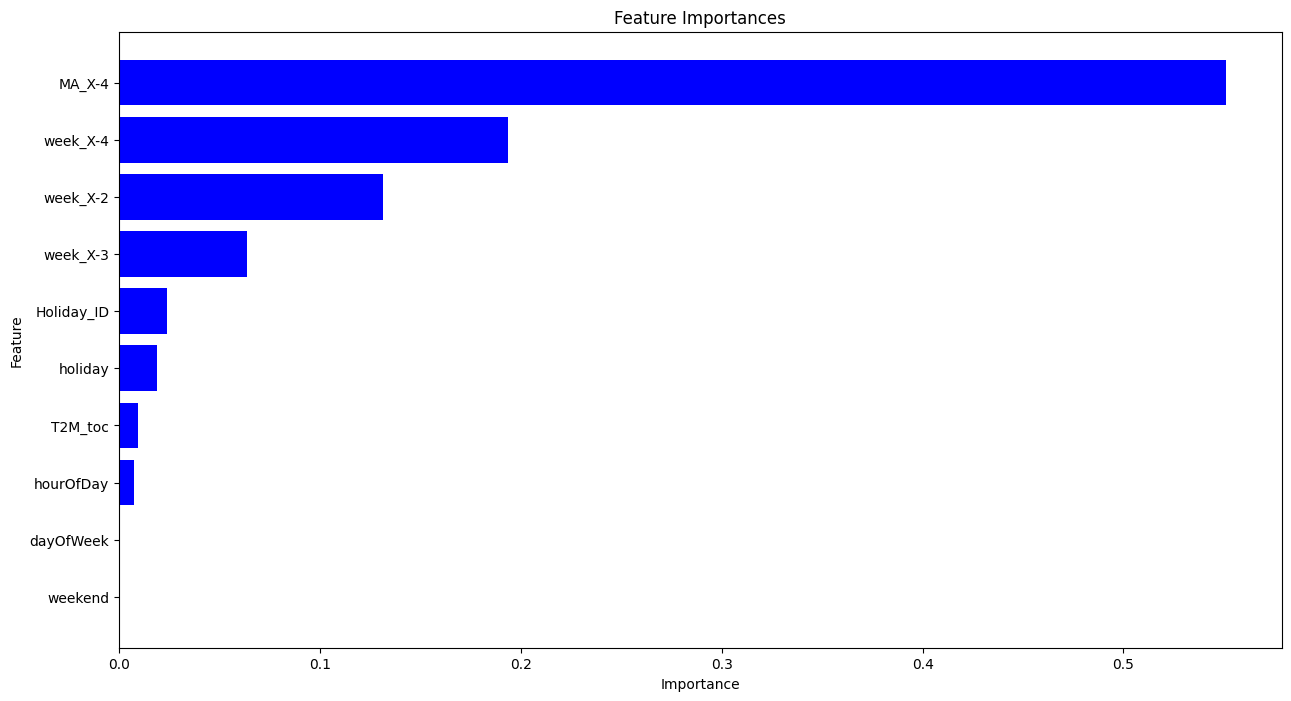

In [10]:
%pip install matplotlib
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Define feature columns and assemble them into a feature vector
feature_columns = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday", "Holiday_ID", "hourOfDay", "T2M_toc"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
# Convert the Pandas DataFrame to a Spark DataFrame
train_data = spark.createDataFrame(pandas_df)
assembled_data = vector_assembler.transform(train_data)

# Scale the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Initialize and fit the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="DEMAND")
rf_model = rf.fit(scaled_data)

# Fetch the feature importances
feature_importances = rf_model.featureImportances.toArray()

# Pair the feature names with their importances and sort
feature_importance_pairs = list(zip(feature_columns, feature_importances))
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Plot the sorted feature importances
sorted_feature_names, sorted_importances = zip(*sorted_feature_importance_pairs)

plt.figure(figsize=(15, 8))
plt.barh(sorted_feature_names, sorted_importances, color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# MA_X-4 (Most Important)
# Temporal Relevance: If MA_X-4 refers to a moving average of some feature (like past electricity consumption) 
# over a period of 4 weeks, it could be capturing long-term trends or seasonality in the data. 
# These trends can be extremely useful for predicting future loads, making the feature highly important.

# Smoothing Noise: Moving averages smooth out noise and fluctuations, which can make the feature more stable and reliable for predictions.

# Reducing Complexity: By capturing trends over a period, the moving average 
# could effectively reduce the complexity the model needs to deal with, making it easier for the model to make accurate predictions.

c:\Users\Jerrod\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jerrod\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


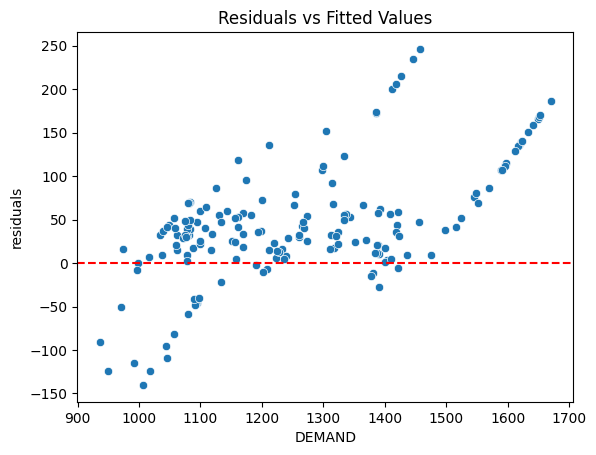

In [11]:
# Calculate residuals
residuals = transformed_test.select("prediction", "DEMAND").toPandas()
residuals['residuals'] = residuals['DEMAND'] - residuals['prediction']

# Create residuals plot
sns.scatterplot(x='DEMAND', y='residuals', data=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.show()


In [12]:

spark_test_df.show()

+-------------------+---------+---------+---------+-----------------+---------+-------+-------+----------+---------+-----------------+---------+
|           datetime| week_X-2| week_X-3| week_X-4|           MA_X-4|dayOfWeek|weekend|holiday|Holiday_ID|hourOfDay|          T2M_toc|   DEMAND|
+-------------------+---------+---------+---------+-----------------+---------+-------+-------+----------+---------+-----------------+---------+
|2019-04-13 01:00:00|1064.7486|1204.5668|1117.8152|       1118.15425|        1|      1|      0|         0|        1|26.79152832031252|1161.6177|
|2019-04-13 02:00:00|1041.7521|1145.5341|1082.5688|       1078.06195|        1|      1|      0|         0|        2|26.70797119140627|1130.4635|
|2019-04-13 03:00:00|1021.1577|1069.8026|1050.1252|      1040.469075|        1|      1|      0|         0|        3|26.61654052734377|1093.8777|
|2019-04-13 04:00:00| 990.2549|  1047.71|1039.1658|      1021.725725|        1|      1|      0|         0|        4|26.54229125976

In [13]:
from pyspark.sql.functions import year, collect_list

# Extract the year from datetime and create a new column 'year'
spark_test_df_with_year = spark_test_df.withColumn('year', year('datetime'))

# Collect distinct years
distinct_years = spark_test_df_with_year.select('year').distinct().collect()

# Convert to Python list
distinct_years_list = [row.year for row in distinct_years]

# Print the list of unique years
print("Unique years:", distinct_years_list)


Unique years: [2019]


In [14]:
from pyspark.sql.functions import month

# Extract the month from datetime and create a new column 'month'
spark_test_df_with_month = spark_test_df.withColumn('month', month('datetime'))

# Collect distinct months
distinct_months = spark_test_df_with_month.select('month').distinct().collect()

# Convert to Python list
distinct_months_list = [row.month for row in distinct_months]

# Print the list of unique months
print("Month number in test data:", distinct_months_list)


Month number in test data: [4]


In [15]:
from pyspark.sql.functions import dayofmonth, to_date, collect_list

# Convert the 'datetime' column to date type and then extract the day
spark_test_df_with_day = spark_test_df.withColumn('day', dayofmonth(to_date('datetime')))

# Filter for the month of April (04) if your datetime is a Timestamp type; adjust accordingly if not
spark_test_df_with_day = spark_test_df_with_day.filter(month('datetime') == 4)

# Collect distinct days
distinct_days = spark_test_df_with_day.select('day').distinct().collect()

# Convert to Python list and sort it
distinct_days_list = sorted([row.day for row in distinct_days])

# Print the list of unique days
print("Days of April in the dataset:", distinct_days_list)


Days of April in the dataset: [13, 14, 15, 16, 17, 18, 19, 20]


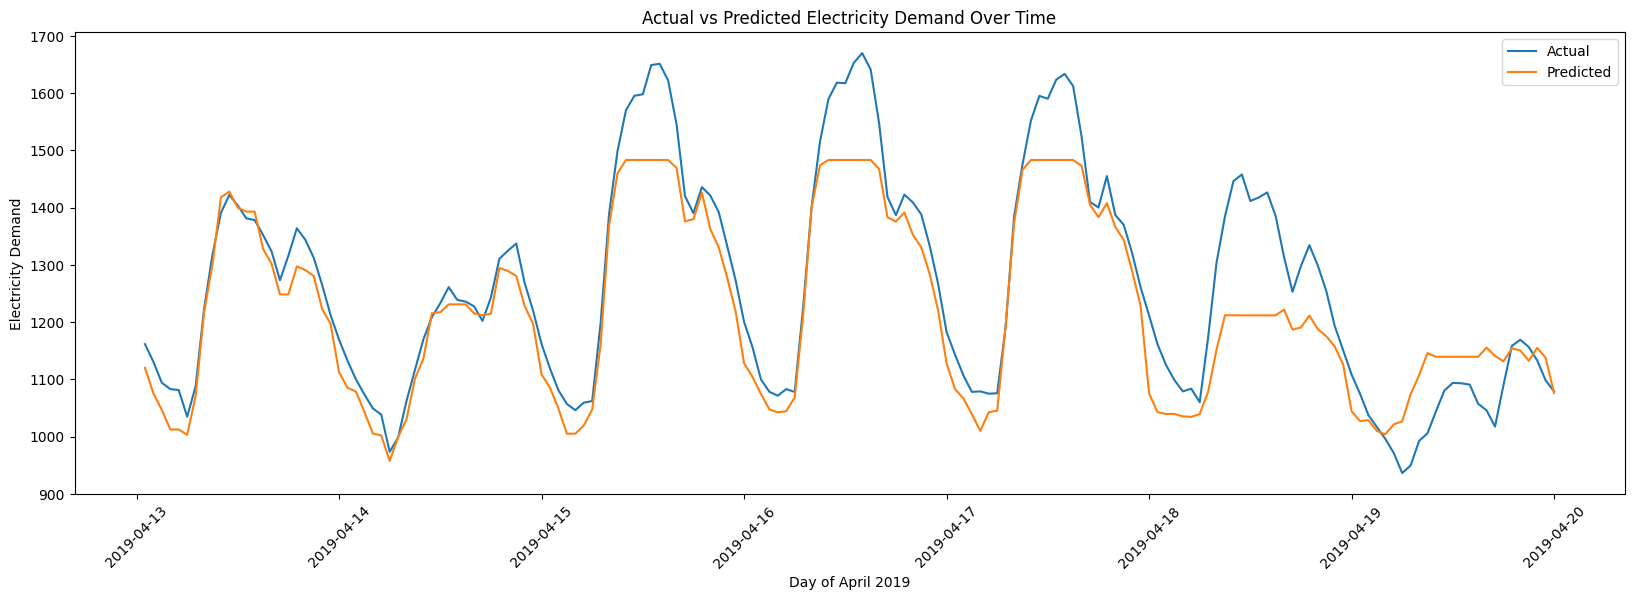

In [16]:
# Run the prediction on the test set
transformed_test = model_rf.transform(spark_test_df)

# Collect the datetime, DEMAND, and prediction columns
result = transformed_test.select(collect_list('datetime'), collect_list('DEMAND'), collect_list('prediction')).first()

# Convert to Python lists
datetime_list = result[0]
demand_list = result[1]
prediction_list = result[2]

# Create the plot
plt.figure(figsize=(20, 6))

plt.plot(datetime_list, demand_list, label='Actual')
plt.plot(datetime_list, prediction_list, label='Predicted')

# Format x-axis to show each day of the month
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Labels and title
plt.xlabel('Day of April 2019')
plt.ylabel('Electricity Demand')
plt.title('Actual vs Predicted Electricity Demand Over Time')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()


In [17]:
# TODO: change x-axis of the above plot to show morning, noon, and evening for each day
# Check the lengths of the lists
print(f"Length of datetime_list: {len(datetime_list)}")
print(f"Length of demand_list: {len(demand_list)}")
print(f"Length of prediction_list: {len(prediction_list)}")

# Check the type of the first element in datetime_list
print(f"Type of first element in datetime_list: {type(datetime_list[0])}")

# Print first 5 elements of each list
print(f"First 5 elements of datetime_list: {datetime_list[:5]}")
print(f"First 5 elements of demand_list: {demand_list[:5]}")
print(f"First 5 elements of prediction_list: {prediction_list[:5]}")

Length of datetime_list: 168
Length of demand_list: 168
Length of prediction_list: 168
Type of first element in datetime_list: <class 'datetime.datetime'>
First 5 elements of datetime_list: [datetime.datetime(2019, 4, 13, 1, 0), datetime.datetime(2019, 4, 13, 2, 0), datetime.datetime(2019, 4, 13, 3, 0), datetime.datetime(2019, 4, 13, 4, 0), datetime.datetime(2019, 4, 13, 5, 0)]
First 5 elements of demand_list: [1161.6177, 1130.4635, 1093.8777, 1083.0332, 1081.2705]
First 5 elements of prediction_list: [1119.9527711811147, 1075.3267839104803, 1046.3880869775944, 1012.4060490071046, 1012.4060490071046]
